<a href="https://colab.research.google.com/github/shayanz97/Markt_Agent/blob/main/My_Agent_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Willkommen bei Colab!

## Lernen Sie die Gemini API kennen
Mit der Gemini API erhalten Sie Zugriff auf von Google DeepMind erstellte Gemini-Modelle. Gemini-Modelle sind von Grund auf multimodal, sodass Sie nahtlos mit Text, Bildern, Code und Audioinhalten arbeiten können.

**Erste Schritte**
*  Rufen Sie <a href="https://aistudio.google.com/">Google AI Studio</a> auf und melden Sie sich mit Ihrem Google-Konto an.
*  <a href="https://aistudio.google.com/app/apikey">Erstellen Sie einen API-Schlüssel.</a>
* Verwenden Sie eine Kurzanleitung für <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb">Python</a> oder rufen Sie die REST API mit <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb">curl</a> auf.

**Erweiterte Funktionen von Gemini**
*  Experimentieren Sie mit den <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb">multimodalen Ausgaben</a> von Gemini, mit denen Sie Text und Bilder auf iterative Weise kombinieren können.
*  Entdecken Sie die <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb">multimodale Live API</a>. Eine Demo <a href="https://aistudio.google.com/live">finden Sie hier</a>.
*  Finden Sie heraus, wie Gemini für Sie <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb&quot;">Bilder analysieren und Objekte darin erkennen</a> kann. Es gibt sogar eine <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb">3D‑Version</a>.
*  Nutzen Sie das leistungsfähige <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb">Gemini-Thinking-Modell</a>, das mit seinen inneren Gedankengängen komplexe Aufgaben lösen kann.
      
**Komplexe Anwendungsfälle**
*  Verwenden Sie die <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb">Gemini-Funktionen zur Fundierung</a>, um Berichte zu Unternehmen zu erstellen, die auf den Ergebnissen basieren, die das Modell im Internet findet.
*  Extrahieren Sie auf strukturierte Weise <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb">Rechnungs- und Formulardaten aus PDFs</a>.
*  Erstellen Sie mit Imagen und dem großen Kontextfenster von Gemini <a href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb">Illustrationen auf Grundlage eines ganzen Buches</a>.

Weitere Informationen finden Sie im <a href="https://github.com/google-gemini/cookbook">Gemini-Cookbook</a> oder in der <a href="https://ai.google.dev/docs/">Gemini API-Dokumentation</a>.


# Markt Agent

In [1]:
# initialise

!pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a4fee58ed26fdbd2ac83cc6869cb0a792cd8d450f9cba86f7fb98fd1f3d8eaf1
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=92a95aed86b993ae05d327c861cfff4f7e301aa0ac9d936a17cf24b35d2f336f
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


## ML Training Code

### v1.0

In [ ]:
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import ta

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '5m'
limit = 3000  # ca. 10-12 Tage bei 5-min Kerzen

exchange = ccxt.kucoin()  # KuCoin Exchange

all_data = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Features ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ma20_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()
        df['ma50_diff'] = (df['close'] - df['close'].rolling(50).mean()) / df['close'].rolling(50).mean()
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()

        # === Bereinigung: NaN / Inf / Extreme Werte ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        # Extremwerte clippen
        for col in ['close_change_pct','ma20_diff','ma50_diff','momentum','vol_change']:
            df[col] = df[col].clip(lower=-10, upper=10)

        # === Target definieren ===
        df['target'] = ((df['close'].shift(-3) - df['close']) / df['close']) > 0.002  # 0.2% Anstieg in 3 Kerzen
        df['target'] = df['target'].astype(int)

        df['coin'] = coin
        all_data.append(df)

    except Exception as e:
        print(f"Error loading {coin}: {e}")

# === Combine all coins ===
data = pd.concat(all_data)

features = ['close_change_pct','rsi','atr','ma20_diff','ma50_diff','momentum','vol_change']
X = data[features]
y = data['target']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === XGBoost Model Training ===
model = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# === Test Accuracy ===
pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

# === Save Model ===
joblib.dump(model, "ml_model_meme_multi_kucoin.pkl")
print("✅ Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin.pkl'")


Accuracy: 0.6885245901639344
✅ Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin.pkl'


### v2.0

In [2]:
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib
import ta

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '5m'
limit = 51840  # mehr Daten für besseres Training

exchange = ccxt.kucoin()  # KuCoin Exchange

all_data = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Features ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ma20_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()
        df['ma50_diff'] = (df['close'] - df['close'].rolling(50).mean()) / df['close'].rolling(50).mean()
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(5).mean()
        df['vol_ma10'] = df['volume'].rolling(10).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10']+1e-8)  # Verhältnis aktuelles Volumen / 10er-MA

        # Candle-Muster (Bullish/Bearish Engulfing)
        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        # === Bereinigung ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        for col in ['close_change_pct','ma20_diff','ma50_diff','momentum','vol_change','vol_ratio']:
            df[col] = df[col].clip(lower=-10, upper=10)

        # === Target: ATR-basiert ===
        df['target'] = ((df['close'].shift(-3) - df['close']) / df['atr']) > 0.5
        df['target'] = df['target'].astype(int)

        df['coin'] = coin
        all_data.append(df)

    except Exception as e:
        print(f"Error loading {coin}: {e}")

# === Combine all coins ===
data = pd.concat(all_data)

features = ['close_change_pct','rsi','atr','ma20_diff','ma50_diff','momentum',
            'vol_change','vol_ma5','vol_ma10','vol_ratio','bull_engulf','bear_engulf']
X = data[features]
y = data['target']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === XGBoost Training (Hyperparameter-optimiert) ===
model = XGBClassifier(n_estimators=500, max_depth=8, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8, random_state=42)
model.fit(X_train, y_train)

# === Test Accuracy ===
pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

# === Save Model ===
joblib.dump(model, "ml_model_meme_multi_kucoin_v2.pkl")
print("✅ Verbesserte Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin_v2.pkl'")


Accuracy: 0.648578811369509
✅ Verbesserte Multi-Coin ML Model gespeichert als 'ml_model_meme_multi_kucoin_v2.pkl'


### v3.0


✅ DOGE/USDT geladen, 1474 Zeilen
✅ SHIB/USDT geladen, 1474 Zeilen
✅ PEPE/USDT geladen, 1474 Zeilen
✅ BONK/USDT geladen, 1471 Zeilen
Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Final Accuracy: 0.8991

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 500, 'scale_pos_weight': np.float64(34.71212121212121), 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95      1098
           1       0.10      0.06      0.08        81

    accuracy                           0.90      1179
   macro avg       0.52      0.51      0.51      1179
weighted avg       0.88      0.90      0.89      1179



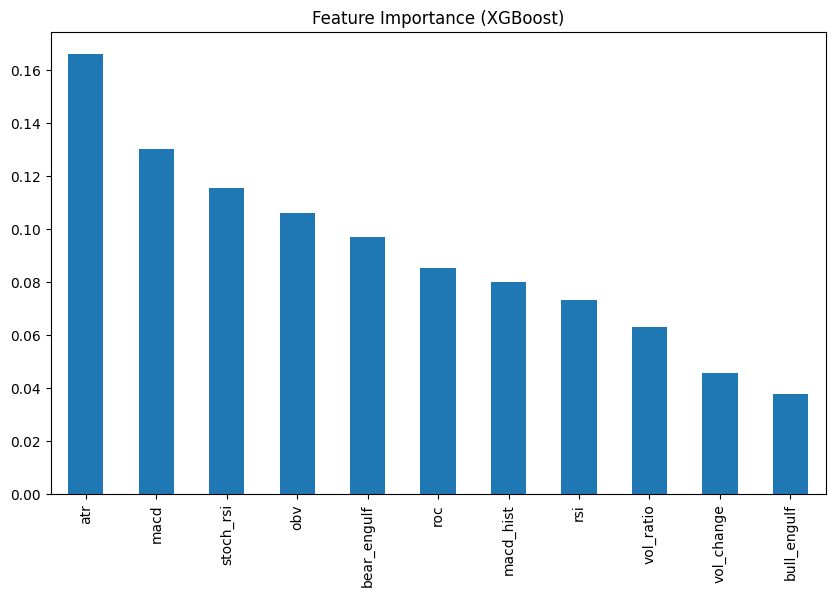

💾 Modell gespeichert als ml_model_meme_kucoin_advanced.pkl


In [3]:
# === INSTALL ===
!pip install ccxt ta xgboost scikit-learn pandas numpy

# === IMPORTS ===
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import joblib
import ta
import warnings
warnings.filterwarnings('ignore')

# === CONFIG ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = "5m"
limit = 5000  # kann erhöht werden, aber 5000 ist stabil für Colab
exchange = ccxt.kucoin()

all_data = []

# === FETCH & FEATURE ENGINEERING ===
for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Technische Indikatoren ===
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ema_fast'] = df['close'].ewm(span=12).mean()
        df['ema_slow'] = df['close'].ewm(span=26).mean()
        df['macd'] = df['ema_fast'] - df['ema_slow']
        df['signal'] = df['macd'].ewm(span=9).mean()
        df['macd_hist'] = df['macd'] - df['signal']
        df['stoch_rsi'] = ta.momentum.StochRSIIndicator(df['close']).stochrsi()
        df['roc'] = ta.momentum.ROCIndicator(df['close']).roc()
        df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()

        # === Candle Features ===
        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        # === Volumen-Dynamik ===
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(5).mean()
        df['vol_ma10'] = df['volume'].rolling(10).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10']+1e-8)

        # === Zielvariable (Target): Kursanstieg in den nächsten 6 Kerzen > 1% ===
        df['target'] = np.where(df['close'].shift(-6) > df['close'] * 1.01, 1, 0)

        # === Bereinigung ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)

        df['coin'] = coin
        all_data.append(df)

        print(f"✅ {coin} geladen, {len(df)} Zeilen")

    except Exception as e:
        print(f"⚠️ Fehler bei {coin}: {e}")

# === Merge all ===
data = pd.concat(all_data)
features = ['rsi','atr','macd','macd_hist','stoch_rsi','roc','obv',
            'vol_change','vol_ratio','bull_engulf','bear_engulf']
X = data[features]
y = data['target']

# === Split (zeitbasiert) ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Weighting to balance classes ===
scale = y_train.value_counts()[0] / y_train.value_counts()[1]

# === GridSearchCV für XGBoost ===
params = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [scale]
}

tscv = TimeSeriesSplit(n_splits=3)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

grid = GridSearchCV(xgb, param_grid=params, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# === Evaluation ===
pred = best_model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"\n✅ Final Accuracy: {acc:.4f}")
print("\nBest Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, pred))

# === Feature Importance ===
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
imp = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
imp.plot(kind='bar')
plt.title("Feature Importance (XGBoost)")
plt.show()

# === Save model ===
joblib.dump(best_model, "ml_model_meme_kucoin_advanced.pkl")
print("💾 Modell gespeichert als ml_model_meme_kucoin_advanced.pkl")


### v4.0


In [5]:
import ccxt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import joblib
import ta

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '5m'
limit = 51840  # 180 Tage bei 5m Daten

exchange = ccxt.kucoin()

all_data = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Feature Engineering ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        df['ma20_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()
        df['ma50_diff'] = (df['close'] - df['close'].rolling(50).mean()) / df['close'].rolling(50).mean()
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(5).mean()
        df['vol_ma10'] = df['volume'].rolling(10).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10'] + 1e-8)

        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        # === Data Cleaning ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        for col in ['close_change_pct', 'ma20_diff', 'ma50_diff', 'momentum', 'vol_change', 'vol_ratio']:
            df[col] = df[col].clip(lower=-10, upper=10)

        # === Softeres Ziel (0.5% Anstieg innerhalb von 6 Kerzen) ===
        future_close = df['close'].shift(-6)
        df['target'] = (future_close > df['close'] * 1.005).astype(int)

        df['coin'] = coin
        all_data.append(df)

    except Exception as e:
        print(f"Error loading {coin}: {e}")

# === Combine all coins ===
data = pd.concat(all_data)

features = ['close_change_pct', 'rsi', 'atr', 'ma20_diff', 'ma50_diff',
            'momentum', 'vol_change', 'vol_ma5', 'vol_ma10', 'vol_ratio',
            'bull_engulf', 'bear_engulf']
X = data[features]
y = data['target']

# === Rebalancing (gleich viele 0er und 1er) ===
pos = data[data['target'] == 1]
neg = data[data['target'] == 0].sample(len(pos), random_state=42)
balanced = pd.concat([pos, neg]).sample(frac=1, random_state=42)

X_bal = balanced[features]
y_bal = balanced['target']

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, shuffle=False)

# === Optimiertes Modell mit Cross-Validation ===
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [6, 8],
    'learning_rate': [0.03, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=1  # da balanciert
)

grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# === Evaluate ===
pred = best_model.predict(X_test)
acc = accuracy_score(y_test, pred)

print(f"\n✅ Final Accuracy: {acc:.4f}")
print(f"\nBest Parameters: {grid.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, pred))

# === Save Model ===
joblib.dump(best_model, "ml_model_meme_multi_kucoin_balanced.pkl")
print("\n✅ Verbesserte & balancierte ML-Datei gespeichert: ml_model_meme_multi_kucoin_balanced.pkl")


Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Final Accuracy: 0.6122

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.57      0.61       159
           1       0.57      0.67      0.61       135

    accuracy                           0.61       294
   macro avg       0.62      0.62      0.61       294
weighted avg       0.62      0.61      0.61       294


✅ Verbesserte & balancierte ML-Datei gespeichert: ml_model_meme_multi_kucoin_balanced.pkl


### v5.0 (LLM-NN)

In [7]:
import ccxt
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === CONFIG ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
timeframe = '5m'
limit = 2000   # ca. 1 Woche Daten pro Coin
seq_len = 30
exchange = ccxt.kucoin()

dfs = []

for coin in coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Indikatoren ===
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
        df['ma20'] = df['close'].rolling(20).mean()
        df['ma50'] = df['close'].rolling(50).mean()
        df['ma_diff'] = (df['ma20'] - df['ma50']) / df['ma50']
        df['vol_change'] = df['volume'].pct_change()

        # === Bereinigung ===
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        df.dropna(inplace=True)

        df['coin'] = coin
        dfs.append(df)

    except Exception as e:
        print(f"Error with {coin}: {e}")

data = pd.concat(dfs)

# === FEATURES ===
features = ['close','volume','rsi','atr','ma_diff','vol_change']

# Fix: Bereinigung VOR dem Scaler!
for col in features:
    data[col] = np.where(np.isfinite(data[col]), data[col], np.nan)
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

# Fix: Clipping extremer Werte
for col in features:
    data[col] = np.clip(data[col], a_min=-1e6, a_max=1e6)

# === Skalierung ===
scaler = StandardScaler()
scaled = scaler.fit_transform(data[features])
scaled_df = pd.DataFrame(scaled, columns=features)

# === Sequenzen ===
X, y = [], []
target_shift = 3
prices = data['close'].values

for i in range(seq_len, len(scaled_df) - target_shift):
    X.append(scaled_df.iloc[i - seq_len:i].values)
    future_return = (prices[i + target_shift] - prices[i]) / prices[i]
    y.append(1 if future_return > 0.005 else 0)

X, y = np.array(X), np.array(y)

# === Split ===
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM MODEL ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_len, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[es], verbose=1)

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ LSTM Accuracy: {acc:.4f}")

model.save("ml_model_lstm_meme_kucoin.h5")
model.save("ml_model_lstm_meme_kucoin.keras")
print("✅ Modell gespeichert als 'ml_model_lstm_meme_kucoin.h5'")


Epoch 1/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8724 - loss: 0.5021 - val_accuracy: 0.9058 - val_loss: 0.3294
Epoch 2/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9354 - loss: 0.2400 - val_accuracy: 0.9058 - val_loss: 0.3279
Epoch 3/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9379 - loss: 0.2288 - val_accuracy: 0.9058 - val_loss: 0.3165
Epoch 4/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9375 - loss: 0.2265 - val_accuracy: 0.9058 - val_loss: 0.3245
Epoch 5/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9335 - loss: 0.2415 - val_accuracy: 0.9058 - val_loss: 0.3113
Epoch 6/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9472 - loss: 0.1976 - val_accuracy: 0.9058 - val_loss: 0.3080
Epoch 7/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9401 - loss: 0.2185 - val_accuracy: 0.9058 - val_loss: 0.3099
Epoch 8/40
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9410 - loss: 0.2155 - val_accuracy: 0.9058 - v

✅ LSTM Accuracy: 0.8853
✅ Modell gespeichert als 'ml_model_lstm_meme_kucoin.h5'


In [8]:
model.save("ml_model_lstm_meme_kucoin.keras")

## Bot

### v1.0 + ML v2.0

In [4]:
import ccxt
import pandas as pd
import numpy as np
import ta
import joblib

# === CONFIGURATION ===
coins = ["DOGE/USDT", "SHIB/USDT", "PEPE/USDT", "BONK/USDT"]
start_balance = 100
interval = '5m'
limit = 5000  # kürzere Testperiode

ml_model_path = "ml_model_meme_kucoin_advanced.pkl"
ml_threshold = 0.6
rsi_buy = 30
rsi_sell = 70

exchange = ccxt.kucoin()
exchange.load_markets()
model = joblib.load(ml_model_path)

results = []
all_trades = []

available_coins = [c for c in coins if c in exchange.markets]
print("Verfügbare Coins für Backtest:", available_coins)

for coin in available_coins:
    try:
        ohlcv = exchange.fetch_ohlcv(coin, interval, limit=limit)
        if len(ohlcv) == 0:
            print(f"No data for {coin}, skipping...")
            continue

        df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
        df['time'] = pd.to_datetime(df['time'], unit='ms')

        # === Features berechnen ===
        df['close_change_pct'] = df['close'].pct_change()
        df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=7).rsi()  # kürzeres RSI
        df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=7).average_true_range()  # kürzeres ATR
        df['ma20_diff'] = (df['close'] - df['close'].rolling(10).mean()) / df['close'].rolling(10).mean()  # kürzeres MA
        df['ma50_diff'] = (df['close'] - df['close'].rolling(20).mean()) / df['close'].rolling(20).mean()  # kürzeres MA
        df['momentum'] = df['close'] - df['close'].shift(3)
        df['vol_change'] = df['volume'].pct_change()
        df['vol_ma5'] = df['volume'].rolling(3).mean()
        df['vol_ma10'] = df['volume'].rolling(5).mean()
        df['vol_ratio'] = df['volume'] / (df['vol_ma10'] + 1e-8)
        df['bull_engulf'] = ((df['close'] > df['open'].shift(1)) & (df['open'] < df['close'].shift(1))).astype(int)
        df['bear_engulf'] = ((df['close'] < df['open'].shift(1)) & (df['open'] > df['close'].shift(1))).astype(int)

        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        features = ['close_change_pct','rsi','atr','ma20_diff','ma50_diff','momentum',
                    'vol_change','vol_ma5','vol_ma10','vol_ratio','bull_engulf','bear_engulf']

        # NaNs sanft füllen
        df[features] = df[features].fillna(method='bfill').fillna(method='ffill')

        balance = start_balance
        position = None
        entry_price = 0
        trades = []

        for i in range(len(df)):
            price = df.loc[i,'close']
            rsi = df.loc[i,'rsi']
            X_current = df.loc[i, features].values.reshape(1,-1)
            ml_score = model.predict_proba(X_current)[0][1]

            # Kaufbedingung
            if position is None and rsi < rsi_buy and ml_score > ml_threshold:
                position = 'LONG'
                entry_price = price
                trades.append({'coin':coin,'time':df.loc[i,'time'],'action':'BUY','price':price,'rsi':rsi,'ml_score':ml_score})

            # Verkauf
            elif position == 'LONG' and (rsi > rsi_sell or ml_score < (1-ml_threshold)):
                profit_pct = (price - entry_price)/entry_price*100
                balance *= (1 + profit_pct/100)
                position = None
                trades.append({'coin':coin,'time':df.loc[i,'time'],'action':'SELL','price':price,'rsi':rsi,'ml_score':ml_score,'profit_%':profit_pct})

        results.append({'coin':coin,'final_balance':balance,'change_%':(balance-start_balance)/start_balance*100})
        all_trades.extend(trades)

    except Exception as e:
        print(f"Error with {coin}: {e}")

# === Export CSV ===
results_df = pd.DataFrame(results)
trades_df = pd.DataFrame(all_trades)
results_df.to_csv("backtest_summary_ml_meme.csv", index=False)
trades_df.to_csv("backtest_trades_ml_meme.csv", index=False)

print("✅ ML+RSI Backtest für Meme-Coins abgeschlossen!")
print(results_df)


Verfügbare Coins für Backtest: ['DOGE/USDT', 'SHIB/USDT', 'PEPE/USDT', 'BONK/USDT']
Error with DOGE/USDT: Feature shape mismatch, expected: 11, got 12
Error with SHIB/USDT: Feature shape mismatch, expected: 11, got 12
Error with PEPE/USDT: Feature shape mismatch, expected: 11, got 12
Error with BONK/USDT: Feature shape mismatch, expected: 11, got 12
✅ ML+RSI Backtest für Meme-Coins abgeschlossen!
Empty DataFrame
Columns: []
Index: []


### v2.0 + ML v5.0

Vorhersage-Statistik:
Min: 0.012446551 Max: 0.32997414 Mittel: 0.057856284
✅ LSTM-Backtest abgeschlossen!
Empty DataFrame
Columns: []
Index: []

Endbalance: 100.00 USDT (Start: 100 USDT, Veränderung: 0.00%)


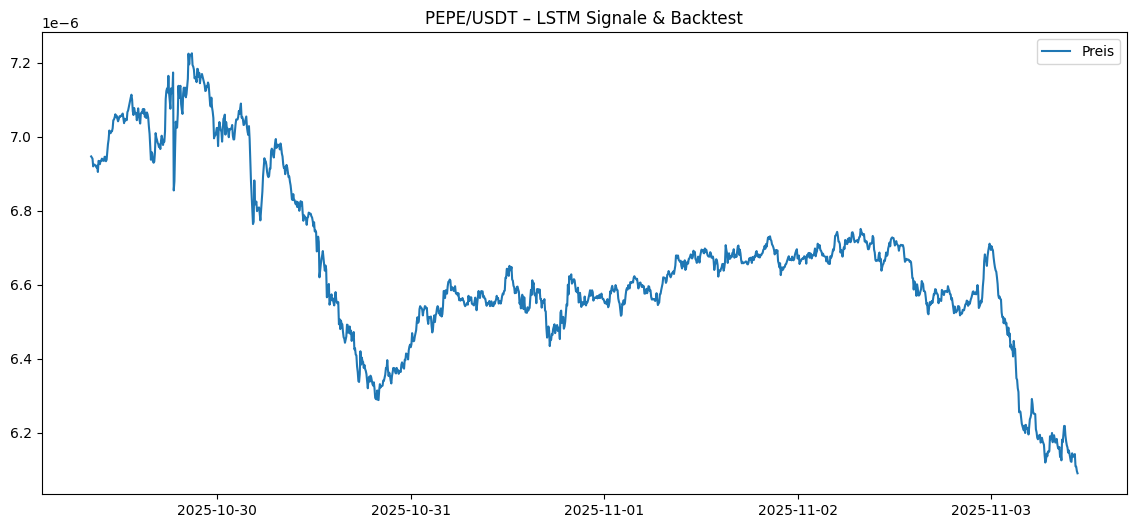

In [13]:
import ccxt
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === SETTINGS ===
coin = "PEPE/USDT"      # du kannst jeden Coin hier einsetzen
timeframe = "5m"
limit = 2000
seq_len = 30
exchange = ccxt.kucoin()

# === Daten abrufen ===
ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
df['time'] = pd.to_datetime(df['time'], unit='ms')

# === Indikatoren ===
df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
df['ma20'] = df['close'].rolling(20).mean()
df['ma50'] = df['close'].rolling(50).mean()
df['ma_diff'] = (df['ma20'] - df['ma50']) / df['ma50']
df['vol_change'] = df['volume'].pct_change()

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# === Feature-Matrix ===
features = ['close','volume','rsi','atr','ma_diff','vol_change']
scaler = StandardScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features)

# === Sequenzen vorbereiten ===
X = []
for i in range(seq_len, len(scaled_df)):
    X.append(scaled_df.iloc[i - seq_len:i].values)
X = np.array(X)

# === Modell laden ===
model = load_model("ml_model_lstm_meme_kucoin.h5")

# === Vorhersagen ===
preds = model.predict(X, verbose=0)
print("Vorhersage-Statistik:")
print("Min:", preds.min(), "Max:", preds.max(), "Mittel:", preds.mean())

df = df.iloc[seq_len:]  # Offset für Sequenz
df["signal"] = (preds > 0.5).astype(int)

# === Backtest-Simulation ===
balance = 100
position = None
entry_price = 0
trades = []

for i in range(len(df)):
    price = df.iloc[i]['close']
    signal = df.iloc[i]['signal']

    # Buy-Signal
    if position is None and signal == 1:
        position = 'LONG'
        entry_price = price
        trades.append({'time': df.iloc[i]['time'], 'action': 'BUY', 'price': price, 'balance': balance})

    # Sell-Signal oder Take Profit / Stop Loss
    elif position == 'LONG' and signal == 0:
        profit_pct = (price - entry_price) / entry_price
        balance *= (1 + profit_pct)
        trades.append({'time': df.iloc[i]['time'], 'action': 'SELL', 'price': price,
                       'profit_%': profit_pct * 100, 'balance': balance})
        position = None

# === Ergebnisse ===
trades_df = pd.DataFrame(trades)
print("✅ LSTM-Backtest abgeschlossen!")
print(trades_df.tail())
print(f"\nEndbalance: {balance:.2f} USDT (Start: 100 USDT, Veränderung: {balance-100:.2f}%)")

# === Plot ===
plt.figure(figsize=(14,6))
plt.plot(df['time'], df['close'], label='Preis')

# Check if trades_df is not empty before plotting buy/sell points
if not trades_df.empty:
    buy_points = trades_df[trades_df['action']=='BUY']
    sell_points = trades_df[trades_df['action']=='SELL']
    plt.scatter(buy_points['time'], buy_points['price'], color='green', label='BUY', marker='^')
    plt.scatter(sell_points['time'], sell_points['price'], color='red', label='SELL', marker='v')

plt.title(f"{coin} – LSTM Signale & Backtest")
plt.legend()
plt.show()

✅ Optimale Schwelle: 0.3
Endbalance: 102.44 USDT (Start: 100 USDT)
                 time action     price     balance  profit_%
0 2025-10-29 18:45:00    BUY  0.000007  100.000000       NaN
1 2025-10-29 19:10:00   SELL  0.000007  102.439724  2.439724


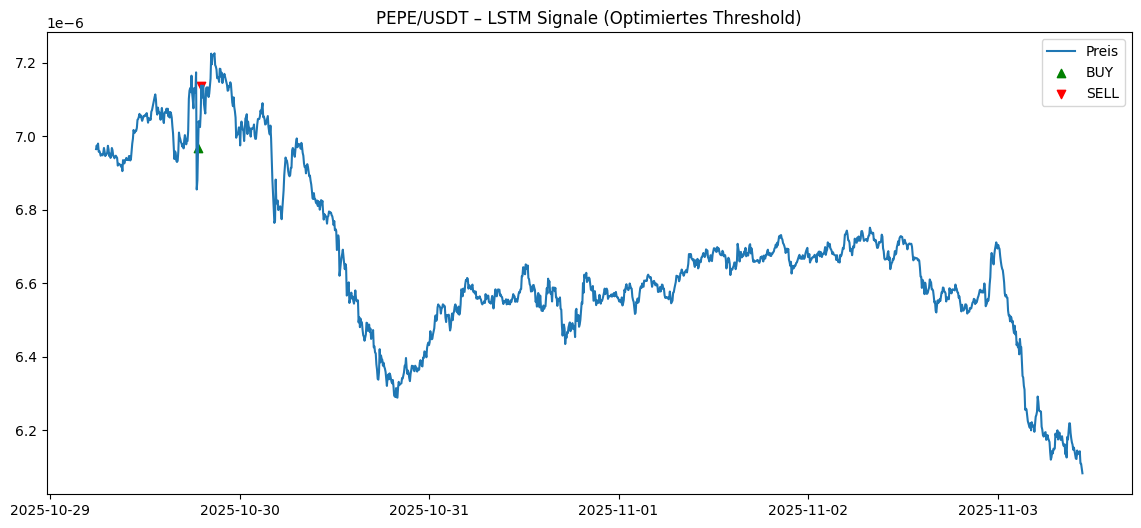

In [14]:
import ccxt
import pandas as pd
import numpy as np
import ta
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === SETTINGS ===
coin = "PEPE/USDT"
timeframe = "5m"
limit = 2000
seq_len = 30
exchange = ccxt.kucoin()

# === Daten abrufen ===
ohlcv = exchange.fetch_ohlcv(coin, timeframe, limit=limit)
df = pd.DataFrame(ohlcv, columns=['time','open','high','low','close','volume'])
df['time'] = pd.to_datetime(df['time'], unit='ms')

# === Indikatoren ===
df['rsi'] = ta.momentum.RSIIndicator(df['close'], 14).rsi()
df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
df['ma20'] = df['close'].rolling(20).mean()
df['ma50'] = df['close'].rolling(50).mean()
df['ma_diff'] = (df['ma20'] - df['ma50']) / df['ma50']
df['vol_change'] = df['volume'].pct_change()

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# === Feature-Matrix ===
features = ['close','volume','rsi','atr','ma_diff','vol_change']
scaler = StandardScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features)

# === Sequenzen vorbereiten ===
X = []
for i in range(seq_len, len(scaled_df)):
    X.append(scaled_df.iloc[i - seq_len:i].values)
X = np.array(X)

# === Modell laden ===
model = load_model("ml_model_lstm_meme_kucoin.h5")
preds = model.predict(X, verbose=0)

# === Test verschiedener Thresholds ===
thresholds = np.arange(0.3, 0.71, 0.05)
best_balance = 0
best_thresh = 0
best_trades = None

for thresh in thresholds:
    df_test = df.iloc[seq_len:].copy()
    df_test['signal'] = (preds > thresh).astype(int)

    balance = 100
    position = None
    entry_price = 0
    trades = []

    for i in range(len(df_test)):
        price = df_test.iloc[i]['close']
        signal = df_test.iloc[i]['signal']

        if position is None and signal == 1:
            position = 'LONG'
            entry_price = price
            trades.append({'time': df_test.iloc[i]['time'], 'action': 'BUY', 'price': price, 'balance': balance})
        elif position == 'LONG' and signal == 0:
            profit_pct = (price - entry_price) / entry_price
            balance *= (1 + profit_pct)
            trades.append({'time': df_test.iloc[i]['time'], 'action': 'SELL', 'price': price,
                           'profit_%': profit_pct*100, 'balance': balance})
            position = None

    if balance > best_balance:
        best_balance = balance
        best_thresh = thresh
        best_trades = trades

# === Ergebnisse anzeigen ===
trades_df = pd.DataFrame(best_trades)
print(f"✅ Optimale Schwelle: {best_thresh}")
print(f"Endbalance: {best_balance:.2f} USDT (Start: 100 USDT)")
print(trades_df.tail())

# === Plot ===
plt.figure(figsize=(14,6))
plt.plot(df['time'], df['close'], label='Preis')
buy_points = trades_df[trades_df['action']=='BUY']
sell_points = trades_df[trades_df['action']=='SELL']
plt.scatter(buy_points['time'], buy_points['price'], color='green', label='BUY', marker='^')
plt.scatter(sell_points['time'], sell_points['price'], color='red', label='SELL', marker='v')
plt.title(f"{coin} – LSTM Signale (Optimiertes Threshold)")
plt.legend()
plt.show()
